In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nirmalgaud/congenital-heart-disease-dataset")

print("Path to dataset files:", path)

100%|██████████| 356M/356M [00:16<00:00, 22.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/nirmalgaud/congenital-heart-disease-dataset/versions/1


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
from collections import Counter

# Set your dataset path
dataset_path = path  # from your kagglehub download
print(f"Dataset location: {dataset_path}")

# Explore directory structure
for root, dirs, files in os.walk(dataset_path):
    level = root.replace(dataset_path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for file in files[:5]:  # Show first 5 files
        print(f"{subindent}{file}")

Dataset location: /root/.cache/kagglehub/datasets/nirmalgaud/congenital-heart-disease-dataset/versions/1
1/
  PDA/
    PDA18.jpg
    PDA123.jpg
    PDA41.jpg
    PDA25.jpg
    PDA190.jpg
  VSD/
    VSD102.jpg
    VSD67.jpg
    VSD62.jpg
    VSD31.jpg
    VSD28.jpg
  Normal/
    CONTROL181.jpg
    CONTROL82.jpg
    CONTROL03.jpg
    CONTROL08.jpg
    CONTROL136.jpg
  ASD/
    ASD43.jpg
    ASD126.jpg
    ASD08.jpg
    ASD74.jpg
    ASD02.jpg


In [ ]:
import shutil

pda_path = path + "/PDA"
shutil.rmtree(pda_path, ignore_errors=True)

print("PDA folder removed.")

PDA folder removed.


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from collections import Counter
from pathlib import Path

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ============ CONFIGURATION ============
dataset_path = path  # Your dataset path
CLASSES = ['Normal', 'ASD', 'VSD']
OUTPUT_DIR = './dataset_exploration'
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("=" * 70)
print("CHD DATASET EXPLORATION & ANALYSIS (3 Classes)")
print("=" * 70)

# ============ 1. CLASS DISTRIBUTION & IMBALANCE ANALYSIS ============
print("\n[1/6] Analyzing Class Distribution & Imbalance...")

def analyze_class_distribution(dataset_path, classes):
    """Analyze class distribution and detect imbalance"""
    class_counts = {}
    class_paths = {}

    for class_name in classes:
        class_path = os.path.join(dataset_path, class_name)
        if os.path.exists(class_path):
            image_files = [f for f in os.listdir(class_path)
                          if f.lower().endswith(('.jpg', '.jpeg', '.png', '.dcm'))]
            class_counts[class_name] = len(image_files)
            class_paths[class_name] = [os.path.join(class_path, f) for f in image_files]
        else:
            print(f"Warning: {class_name} folder not found!")
            class_counts[class_name] = 0
            class_paths[class_name] = []

    return class_counts, class_paths

class_counts, class_paths = analyze_class_distribution(dataset_path, CLASSES)

# Create DataFrame for analysis
df_classes = pd.DataFrame({
    'Class': list(class_counts.keys()),
    'Count': list(class_counts.values()),
    'Percentage': [count/sum(class_counts.values())*100 for count in class_counts.values()]
})

print("\nClass Distribution:")
print(df_classes.to_string(index=False))

# Calculate imbalance metrics
total_images = sum(class_counts.values())
max_count = max(class_counts.values())
min_count = min(class_counts.values())
imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')

print(f"\nTotal Images: {total_images}")
print(f"Imbalance Ratio: {imbalance_ratio:.2f}:1")

if imbalance_ratio > 2.0:
    print("  SEVERE CLASS IMBALANCE detected!")
    print("  Recommendation: Use class weights or oversampling")
elif imbalance_ratio > 1.5:
    print("  MODERATE CLASS IMBALANCE detected")
    print("  Recommendation: Consider class weights")
else:
    print("  Dataset is relatively balanced")

# Plot 1: Class Distribution Bar Chart
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
axes[0].bar(df_classes['Class'], df_classes['Count'],
           color=['#3498db', '#e74c3c', '#2ecc71'], alpha=0.8, edgecolor='black')
axes[0].set_xlabel('Class', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Images', fontsize=12, fontweight='bold')
axes[0].set_title('Class Distribution', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (cls, count) in enumerate(zip(df_classes['Class'], df_classes['Count'])):
    axes[0].text(i, count + max_count*0.02, str(count),
                ha='center', va='bottom', fontweight='bold')

# Pie chart
colors = ['#3498db', '#e74c3c', '#2ecc71']
explode = [0.05 if count == max_count else 0 for count in df_classes['Count']]
axes[1].pie(df_classes['Count'], labels=df_classes['Class'], autopct='%1.1f%%',
           colors=colors, explode=explode, startangle=90,
           textprops={'fontsize': 11, 'fontweight': 'bold'})
axes[1].set_title('Class Distribution (%)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/01_class_distribution.png', dpi=300, bbox_inches='tight')
print(f"\nSaved: {OUTPUT_DIR}/01_class_distribution.png")
plt.close()

# ============ 2. IMAGE DIMENSION ANALYSIS ============
print("\n[2/6] Analyzing Image Dimensions...")

def analyze_image_dimensions(class_paths, sample_size=100):
    """Analyze image dimensions, aspect ratios, and file sizes"""
    dimensions = []
    aspect_ratios = []
    file_sizes = []
    channels_list = []
    class_labels = []

    for class_name, paths in class_paths.items():
        sample_paths = paths[:min(sample_size, len(paths))]

        for img_path in sample_paths:
            try:
                img = Image.open(img_path)
                width, height = img.size
                dimensions.append((width, height))
                aspect_ratios.append(width / height)
                file_sizes.append(os.path.getsize(img_path) / 1024)  # KB

                img_array = np.array(img)
                channels = img_array.shape[2] if len(img_array.shape) == 3 else 1
                channels_list.append(channels)
                class_labels.append(class_name)
            except Exception as e:
                print(f"  Error reading {img_path}: {e}")

    return dimensions, aspect_ratios, file_sizes, channels_list, class_labels

dims, aspect_ratios, file_sizes, channels, dim_labels = analyze_image_dimensions(class_paths)

# Dimension statistics
widths = [d[0] for d in dims]
heights = [d[1] for d in dims]

print(f"\nImage Dimension Statistics (sampled {len(dims)} images):")
print(f"  Width:  Min={min(widths)}, Max={max(widths)}, Mean={np.mean(widths):.1f}, Std={np.std(widths):.1f}")
print(f"  Height: Min={min(heights)}, Max={max(heights)}, Mean={np.mean(heights):.1f}, Std={np.std(heights):.1f}")
print(f"  Aspect Ratio: Mean={np.mean(aspect_ratios):.2f}, Std={np.std(aspect_ratios):.2f}")
print(f"  File Size (KB): Mean={np.mean(file_sizes):.1f}, Std={np.std(file_sizes):.1f}")
print(f"  Channels: {Counter(channels)}")

# Plot 2: Image Dimension Distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Width distribution
axes[0, 0].hist(widths, bins=30, color='#3498db', alpha=0.7, edgecolor='black')
axes[0, 0].axvline(np.mean(widths), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(widths):.0f}')
axes[0, 0].set_xlabel('Width (pixels)', fontweight='bold')
axes[0, 0].set_ylabel('Frequency', fontweight='bold')
axes[0, 0].set_title('Image Width Distribution', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Height distribution
axes[0, 1].hist(heights, bins=30, color='#e74c3c', alpha=0.7, edgecolor='black')
axes[0, 1].axvline(np.mean(heights), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(heights):.0f}')
axes[0, 1].set_xlabel('Height (pixels)', fontweight='bold')
axes[0, 1].set_ylabel('Frequency', fontweight='bold')
axes[0, 1].set_title('Image Height Distribution', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Aspect ratio distribution
axes[1, 0].hist(aspect_ratios, bins=30, color='#2ecc71', alpha=0.7, edgecolor='black')
axes[1, 0].axvline(np.mean(aspect_ratios), color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {np.mean(aspect_ratios):.2f}')
axes[1, 0].set_xlabel('Aspect Ratio (Width/Height)', fontweight='bold')
axes[1, 0].set_ylabel('Frequency', fontweight='bold')
axes[1, 0].set_title('Aspect Ratio Distribution', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# File size distribution
axes[1, 1].hist(file_sizes, bins=30, color='#9b59b6', alpha=0.7, edgecolor='black')
axes[1, 1].axvline(np.mean(file_sizes), color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {np.mean(file_sizes):.1f} KB')
axes[1, 1].set_xlabel('File Size (KB)', fontweight='bold')
axes[1, 1].set_ylabel('Frequency', fontweight='bold')
axes[1, 1].set_title('File Size Distribution', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/02_image_dimensions.png', dpi=300, bbox_inches='tight')
print(f"Saved: {OUTPUT_DIR}/02_image_dimensions.png")
plt.close()

# ============ 3. PIXEL INTENSITY ANALYSIS ============
print("\n[3/6] Analyzing Pixel Intensities...")

def analyze_pixel_intensities(class_paths, sample_size=50):
    """Analyze pixel intensity distributions"""
    intensity_stats = {cls: {'mean': [], 'std': [], 'min': [], 'max': []}
                      for cls in CLASSES}

    for class_name, paths in class_paths.items():
        sample_paths = paths[:min(sample_size, len(paths))]

        for img_path in sample_paths:
            try:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    intensity_stats[class_name]['mean'].append(np.mean(img))
                    intensity_stats[class_name]['std'].append(np.std(img))
                    intensity_stats[class_name]['min'].append(np.min(img))
                    intensity_stats[class_name]['max'].append(np.max(img))
            except:
                pass

    return intensity_stats

intensity_stats = analyze_pixel_intensities(class_paths)

print("\nPixel Intensity Statistics:")
for cls in CLASSES:
    if intensity_stats[cls]['mean']:
        print(f"\n  {cls}:")
        print(f"    Mean Intensity: {np.mean(intensity_stats[cls]['mean']):.2f} +/- {np.std(intensity_stats[cls]['mean']):.2f}")
        print(f"    Std Dev:        {np.mean(intensity_stats[cls]['std']):.2f} +/- {np.std(intensity_stats[cls]['std']):.2f}")

# Plot 3: Pixel Intensity Box Plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Mean intensity boxplot
mean_data = [intensity_stats[cls]['mean'] for cls in CLASSES]
bp1 = axes[0].boxplot(mean_data, labels=CLASSES, patch_artist=True,
                      boxprops=dict(facecolor='lightblue', alpha=0.7),
                      medianprops=dict(color='red', linewidth=2))
axes[0].set_ylabel('Mean Pixel Intensity', fontweight='bold')
axes[0].set_title('Mean Pixel Intensity by Class', fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Std dev boxplot
std_data = [intensity_stats[cls]['std'] for cls in CLASSES]
bp2 = axes[1].boxplot(std_data, labels=CLASSES, patch_artist=True,
                      boxprops=dict(facecolor='lightcoral', alpha=0.7),
                      medianprops=dict(color='darkred', linewidth=2))
axes[1].set_ylabel('Std Dev of Pixel Intensity', fontweight='bold')
axes[1].set_title('Pixel Intensity Variation by Class', fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/03_pixel_intensity.png', dpi=300, bbox_inches='tight')
print(f"Saved: {OUTPUT_DIR}/03_pixel_intensity.png")
plt.close()

# ============ 4. SAMPLE IMAGE VISUALIZATION ============
print("\n[4/6] Creating Sample Image Grid...")

def visualize_sample_images(class_paths, samples_per_class=5):
    """Display sample images from each class"""
    fig, axes = plt.subplots(len(CLASSES), samples_per_class,
                            figsize=(15, len(CLASSES)*3))

    for i, class_name in enumerate(CLASSES):
        sample_paths = class_paths[class_name][:samples_per_class]

        for j, img_path in enumerate(sample_paths):
            try:
                img = Image.open(img_path)
                if len(CLASSES) == 1:
                    ax = axes[j]
                else:
                    ax = axes[i, j]

                ax.imshow(img, cmap='gray' if img.mode == 'L' else None)
                ax.axis('off')

                if j == 0:
                    ax.set_title(f"{class_name}\n({class_counts[class_name]} images)",
                               fontweight='bold', fontsize=11)
            except Exception as e:
                if len(CLASSES) == 1:
                    axes[j].text(0.5, 0.5, 'Error loading', ha='center', va='center')
                else:
                    axes[i, j].text(0.5, 0.5, 'Error loading', ha='center', va='center')

    plt.suptitle('Sample Images from Each Class', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}/04_sample_images.png', dpi=300, bbox_inches='tight')
    print(f"Saved: {OUTPUT_DIR}/04_sample_images.png")
    plt.close()

visualize_sample_images(class_paths, samples_per_class=5)

# ============ 5. IMAGE QUALITY METRICS ============
print("\n[5/6] Computing Image Quality Metrics...")

def compute_image_quality(class_paths, sample_size=30):
    """Compute contrast, brightness, and sharpness metrics"""
    quality_metrics = {cls: {'contrast': [], 'brightness': [], 'sharpness': []}
                      for cls in CLASSES}

    for class_name, paths in class_paths.items():
        sample_paths = paths[:min(sample_size, len(paths))]

        for img_path in sample_paths:
            try:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    # Contrast (std dev of pixel intensities)
                    contrast = np.std(img)
                    quality_metrics[class_name]['contrast'].append(contrast)

                    # Brightness (mean pixel intensity)
                    brightness = np.mean(img)
                    quality_metrics[class_name]['brightness'].append(brightness)

                    # Sharpness (Laplacian variance)
                    laplacian = cv2.Laplacian(img, cv2.CV_64F)
                    sharpness = laplacian.var()
                    quality_metrics[class_name]['sharpness'].append(sharpness)
            except:
                pass

    return quality_metrics

quality_metrics = compute_image_quality(class_paths)

print("\nImage Quality Metrics:")
for cls in CLASSES:
    if quality_metrics[cls]['contrast']:
        print(f"\n  {cls}:")
        print(f"    Contrast:   {np.mean(quality_metrics[cls]['contrast']):.2f} +/- {np.std(quality_metrics[cls]['contrast']):.2f}")
        print(f"    Brightness: {np.mean(quality_metrics[cls]['brightness']):.2f} +/- {np.std(quality_metrics[cls]['brightness']):.2f}")
        print(f"    Sharpness:  {np.mean(quality_metrics[cls]['sharpness']):.2f} +/- {np.std(quality_metrics[cls]['sharpness']):.2f}")

# Plot 5: Quality Metrics Comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['contrast', 'brightness', 'sharpness']
titles = ['Contrast (Std Dev)', 'Brightness (Mean Intensity)', 'Sharpness (Laplacian Var)']
colors = ['#3498db', '#e74c3c', '#2ecc71']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    data = [quality_metrics[cls][metric] for cls in CLASSES]
    bp = axes[idx].boxplot(data, labels=CLASSES, patch_artist=True)

    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    axes[idx].set_ylabel(title, fontweight='bold')
    axes[idx].set_title(f'{title} by Class', fontweight='bold')
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/05_quality_metrics.png', dpi=300, bbox_inches='tight')
print(f"Saved: {OUTPUT_DIR}/05_quality_metrics.png")
plt.close()

# ============ 6. COMPREHENSIVE SUMMARY REPORT ============
print("\n[6/6] Generating Summary Report...")

summary_report = f"""
{'='*70}
CHD DATASET EXPLORATION SUMMARY REPORT
{'='*70}

1. DATASET OVERVIEW
   - Total Images: {total_images}
   - Number of Classes: {len(CLASSES)}
   - Classes: {', '.join(CLASSES)}

2. CLASS DISTRIBUTION
   {df_classes.to_string(index=False)}

   Imbalance Ratio: {imbalance_ratio:.2f}:1
   Status: {'SEVERE IMBALANCE' if imbalance_ratio > 2.0 else 'MODERATE IMBALANCE' if imbalance_ratio > 1.5 else 'BALANCED'}

3. IMAGE CHARACTERISTICS
   - Width Range: {min(widths)} - {max(widths)} pixels (Mean: {np.mean(widths):.1f})
   - Height Range: {min(heights)} - {max(heights)} pixels (Mean: {np.mean(heights):.1f})
   - Aspect Ratio: {np.mean(aspect_ratios):.2f} +/- {np.std(aspect_ratios):.2f}
   - File Size: {np.mean(file_sizes):.1f} +/- {np.std(file_sizes):.1f} KB
   - Color Channels: {Counter(channels)}

4. RECOMMENDATIONS
   {'- Apply class weighting or data augmentation due to imbalance' if imbalance_ratio > 1.5 else '- Dataset is balanced, no special handling needed'}
   - Resize all images to 224x224 for ConvNeXt
   - Apply data augmentation: rotation (+/-10 degrees), flipping, brightness/contrast adjustment
   - Use stratified splitting to maintain class distribution

{'='*70}
"""

# Save report with UTF-8 encoding
with open(f'{OUTPUT_DIR}/dataset_summary_report.txt', 'w', encoding='utf-8') as f:
    f.write(summary_report)

print(summary_report)
print(f"\nSummary report saved: {OUTPUT_DIR}/dataset_summary_report.txt")

print("\n" + "="*70)
print("DATASET EXPLORATION COMPLETE!")
print("="*70)
print(f"\nAll visualizations saved to: {OUTPUT_DIR}/")
print("\nGenerated files:")
print("  1. 01_class_distribution.png")
print("  2. 02_image_dimensions.png")
print("  3. 03_pixel_intensity.png")
print("  4. 04_sample_images.png")
print("  5. 05_quality_metrics.png")
print("  6. dataset_summary_report.txt")

CHD DATASET EXPLORATION & ANALYSIS (3 Classes)

[1/6] Analyzing Class Distribution & Imbalance...

Class Distribution:
 Class  Count  Percentage
Normal    208   33.986928
   ASD    194   31.699346
   VSD    210   34.313725

Total Images: 612
Imbalance Ratio: 1.08:1
  Dataset is relatively balanced

Saved: ./dataset_exploration/01_class_distribution.png

[2/6] Analyzing Image Dimensions...

Image Dimension Statistics (sampled 300 images):
  Width:  Min=222, Max=3260, Mean=1472.4, Std=734.3
  Height: Min=174, Max=3056, Mean=1270.7, Std=628.9
  Aspect Ratio: Mean=1.16, Std=0.19
  File Size (KB): Mean=555.4, Std=342.5
  Channels: Counter({1: 244, 3: 56})
Saved: ./dataset_exploration/02_image_dimensions.png

[3/6] Analyzing Pixel Intensities...

Pixel Intensity Statistics:

  Normal:
    Mean Intensity: 111.84 +/- 8.91
    Std Dev:        72.83 +/- 4.13

  ASD:
    Mean Intensity: 118.37 +/- 16.26
    Std Dev:        71.61 +/- 7.55

  VSD:
    Mean Intensity: 103.71 +/- 12.41
    Std Dev:  

/tmp/ipython-input-230035014.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = axes[0].boxplot(mean_data, labels=CLASSES, patch_artist=True,
/tmp/ipython-input-230035014.py:243: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = axes[1].boxplot(std_data, labels=CLASSES, patch_artist=True,


Saved: ./dataset_exploration/03_pixel_intensity.png

[4/6] Creating Sample Image Grid...
Saved: ./dataset_exploration/04_sample_images.png

[5/6] Computing Image Quality Metrics...

Image Quality Metrics:

  Normal:
    Contrast:   72.73 +/- 4.32
    Brightness: 112.01 +/- 10.45
    Sharpness:  241.46 +/- 151.73

  ASD:
    Contrast:   70.23 +/- 8.61
    Brightness: 119.76 +/- 16.96
    Sharpness:  109.69 +/- 117.61

  VSD:
    Contrast:   69.60 +/- 8.83
    Brightness: 102.39 +/- 13.20
    Sharpness:  641.92 +/- 293.17


/tmp/ipython-input-230035014.py:345: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[idx].boxplot(data, labels=CLASSES, patch_artist=True)
/tmp/ipython-input-230035014.py:345: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[idx].boxplot(data, labels=CLASSES, patch_artist=True)
/tmp/ipython-input-230035014.py:345: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[idx].boxplot(data, labels=CLASSES, patch_artist=True)


Saved: ./dataset_exploration/05_quality_metrics.png

[6/6] Generating Summary Report...

CHD DATASET EXPLORATION SUMMARY REPORT

1. DATASET OVERVIEW
   - Total Images: 612
   - Number of Classes: 3
   - Classes: Normal, ASD, VSD

2. CLASS DISTRIBUTION
    Class  Count  Percentage
Normal    208   33.986928
   ASD    194   31.699346
   VSD    210   34.313725
   
   Imbalance Ratio: 1.08:1
   Status: BALANCED

3. IMAGE CHARACTERISTICS
   - Width Range: 222 - 3260 pixels (Mean: 1472.4)
   - Height Range: 174 - 3056 pixels (Mean: 1270.7)
   - Aspect Ratio: 1.16 +/- 0.19
   - File Size: 555.4 +/- 342.5 KB
   - Color Channels: Counter({1: 244, 3: 56})

4. RECOMMENDATIONS
   - Dataset is balanced, no special handling needed
   - Resize all images to 224x224 for ConvNeXt
   - Apply data augmentation: rotation (+/-10 degrees), flipping, brightness/contrast adjustment
   - Use stratified splitting to maintain class distribution



Summary report saved: ./dataset_exploration/dataset_summary_report

In [ ]:
!pip install -q transformers evaluate datasets accelerate tf-keras


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.5 MB/s eta 0:00:00


🚀 CHD Classification - ConvNeXt Training
GPU: Tesla T4

[1/7] Loading dataset...
✓ Total: 612 images
  Normal    : 208 images
  ASD       : 194 images
  VSD       : 210 images

[2/7] Splitting data...
✓ Train: 428, Val: 92, Test: 92

[3/7] Loading ConvNeXt...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/354M [00:00<?, ?B/s]

Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-base-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([3, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model loaded with 87,569,539 parameters

[4/7] Creating datasets...
✓ Datasets ready

[5/7] Setting up metrics...


model.safetensors:   0%|          | 0.00/354M [00:00<?, ?B/s]


[6/7] Configuring training...

[7/7] Training...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.079800,1.068274,0.456522,0.412104
2,1.046600,1.023745,0.510870,0.509197
3,0.911000,0.956676,0.565217,0.565081
4,0.827400,0.923011,0.641304,0.632737
5,0.790500,0.836025,0.728261,0.724910
6,0.658700,0.777934,0.739130,0.734017
7,0.590900,0.705462,0.739130,0.738389
8,0.508200,0.741042,0.663043,0.665155
9,0.432000,0.681650,0.739130,0.736833
10,0.376500,0.674275,0.739130,0.731879



✅ Training complete!

📊 Test Results:


  Accuracy: 79.35%
  F1 Score: 0.7902


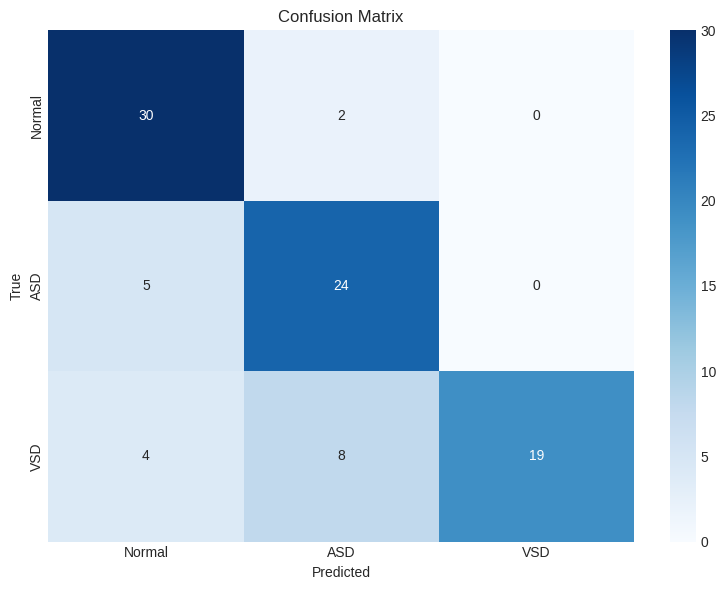


              precision    recall  f1-score   support

      Normal       0.77      0.94      0.85        32
         ASD       0.71      0.83      0.76        29
         VSD       1.00      0.61      0.76        31

    accuracy                           0.79        92
   macro avg       0.83      0.79      0.79        92
weighted avg       0.83      0.79      0.79        92


✅ Done! Model saved to: ./chd_model/final_model


In [ ]:
import os
os.environ['TRANSFORMERS_NO_TF'] = '1'

import torch
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
from transformers import (
    AutoImageProcessor,
    ConvNextForImageClassification,
    TrainingArguments,
    Trainer
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter
import torchvision.transforms as T
import evaluate
import matplotlib.pyplot as plt
import seaborn as sns

# ============ GPU CHECK ============
print("=" * 70)
print("🚀 CHD Classification - ConvNeXt Training")
print("=" * 70)
print(f"GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")
print("=" * 70)

# ============ CONFIG ============
# Use the path from kagglehub (or your prepared dataset path)
dataset_path = path  # Your kagglehub dataset path
OUTPUT_DIR = './chd_model'
os.makedirs(OUTPUT_DIR, exist_ok=True)

CLASSES = ['Normal', 'ASD', 'VSD']  # No PDA since you dropped it
class_to_idx = {cls: idx for idx, cls in enumerate(CLASSES)}
idx_to_class = {idx: cls for cls, idx in class_to_idx.items()}

BATCH_SIZE = 16
EPOCHS = 25
LEARNING_RATE = 2e-5

# ============ LOAD DATASET ============
print("\n[1/7] Loading dataset...")

def load_dataset(dataset_path):
    image_paths, labels = [], []
    for class_name in CLASSES:
        class_path = os.path.join(dataset_path, class_name)
        if os.path.exists(class_path):
            for img_file in os.listdir(class_path):
                if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_paths.append(os.path.join(class_path, img_file))
                    labels.append(class_to_idx[class_name])
    return image_paths, labels

image_paths, labels = load_dataset(dataset_path)
print(f"✓ Total: {len(image_paths)} images")

for cls_idx, count in sorted(Counter(labels).items()):
    print(f"  {CLASSES[cls_idx]:10s}: {count} images")

# ============ SPLIT ============
print("\n[2/7] Splitting data...")

train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels, test_size=0.3, stratify=labels, random_state=42
)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

print(f"✓ Train: {len(train_paths)}, Val: {len(val_paths)}, Test: {len(test_paths)}")

# ============ LOAD MODEL ============
print("\n[3/7] Loading ConvNeXt...")

model_name = "facebook/convnext-base-224"
processor = AutoImageProcessor.from_pretrained(model_name)
model = ConvNextForImageClassification.from_pretrained(
    model_name,
    num_labels=3,
    id2label=idx_to_class,
    label2id=class_to_idx,
    ignore_mismatched_sizes=True
)

print(f"✓ Model loaded with {sum(p.numel() for p in model.parameters()):,} parameters")

# ============ DATASET CLASS ============
print("\n[4/7] Creating datasets...")

class CHDDataset(Dataset):
    def __init__(self, image_paths, labels, processor, augment=False):
        self.image_paths = image_paths
        self.labels = labels
        self.processor = processor
        self.augment = augment

        if augment:
            self.augmentation = T.Compose([
                T.RandomHorizontalFlip(p=0.5),
                T.RandomRotation(degrees=10),
                T.ColorJitter(brightness=0.2, contrast=0.2),
                T.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.augment and self.augmentation:
            image = self.augmentation(image)

        encoding = self.processor(image, return_tensors='pt')
        encoding = {k: v.squeeze(0) for k, v in encoding.items()}
        encoding['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return encoding

train_dataset = CHDDataset(train_paths, train_labels, processor, augment=True)
val_dataset = CHDDataset(val_paths, val_labels, processor, augment=False)
test_dataset = CHDDataset(test_paths, test_labels, processor, augment=False)

print("✓ Datasets ready")

# ============ METRICS ============
print("\n[5/7] Setting up metrics...")

accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        'accuracy': accuracy_metric.compute(predictions=predictions, references=labels)['accuracy'],
        'f1': f1_metric.compute(predictions=predictions, references=labels, average='weighted')['f1'],
    }

# ============ TRAINING ARGS ============
print("\n[6/7] Configuring training...")

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    weight_decay=0.05,
    warmup_ratio=0.1,
    eval_strategy='epoch',
    save_strategy='epoch',
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    logging_steps=20,
    fp16=True,
    remove_unused_columns=False,
    report_to='none',
)

# ============ TRAIN ============
print("\n[7/7] Training...")
print("=" * 70)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.save_model(f'{OUTPUT_DIR}/final_model')
processor.save_pretrained(f'{OUTPUT_DIR}/final_model')

print("\n✅ Training complete!")

# ============ EVALUATE ============
print("\n📊 Test Results:")

test_results = trainer.evaluate(test_dataset)
print(f"  Accuracy: {test_results['eval_accuracy']*100:.2f}%")
print(f"  F1 Score: {test_results['eval_f1']:.4f}")

# Confusion Matrix
predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=-1)
cm = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/confusion_matrix.png', dpi=300)
plt.show()

print("\n" + classification_report(test_labels, predicted_labels, target_names=CLASSES))
print("\n✅ Done! Model saved to:", f'{OUTPUT_DIR}/final_model')


In [ ]:
# Zip the model
!zip -r chd_model.zip ./chd_model/final_model

# Download to your computer
from google.colab import files
files.download('chd_model.zip')


  adding: chd_model/final_model/ (stored 0%)
  adding: chd_model/final_model/model.safetensors (deflated 7%)
  adding: chd_model/final_model/config.json (deflated 52%)
  adding: chd_model/final_model/preprocessor_config.json (deflated 44%)
  adding: chd_model/final_model/training_args.bin (deflated 53%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Prediction code

Loading trained model...
✓ Model loaded on cuda

SAMPLE PREDICTIONS

Image 1: CONTROL37.jpg
  True Label: Normal
  Predicted:  Normal (96.93% confidence)
  All probabilities:
    Normal    : 96.93%
    ASD       : 1.58%
    VSD       : 1.49%
  ✓ Correct

Image 2: VSD206.jpg
  True Label: VSD
  Predicted:  VSD (96.15% confidence)
  All probabilities:
    Normal    : 0.53%
    ASD       : 3.32%
    VSD       : 96.15%
  ✓ Correct

Image 3: CONTROL166.jpg
  True Label: Normal
  Predicted:  Normal (89.51% confidence)
  All probabilities:
    Normal    : 89.51%
    ASD       : 8.17%
    VSD       : 2.32%
  ✓ Correct


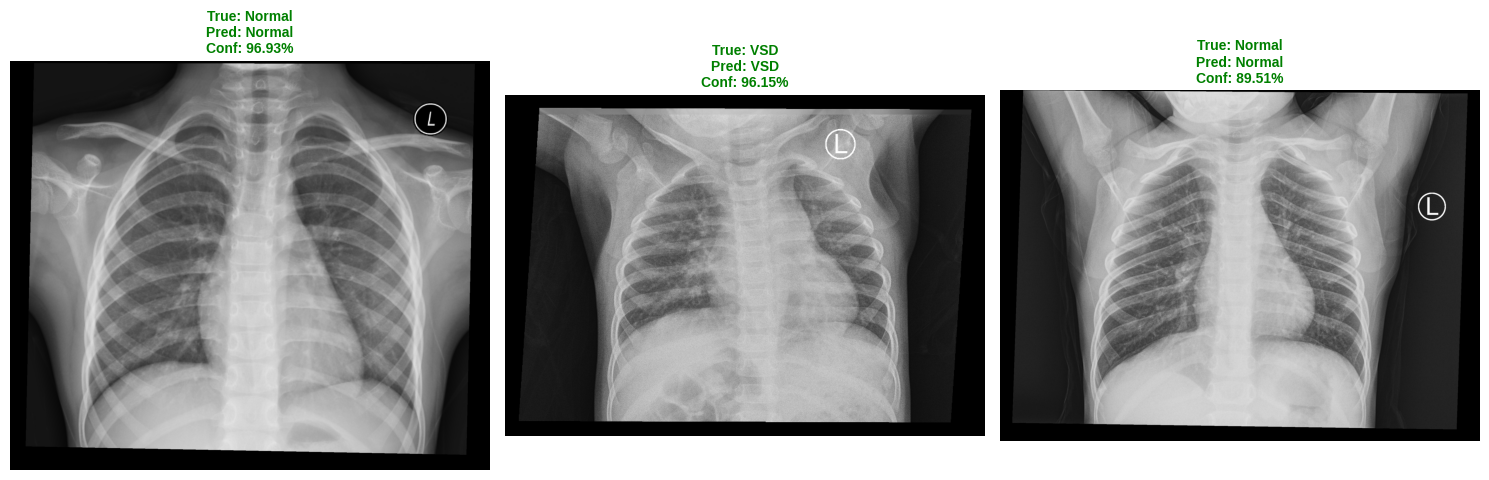


✓ Sample predictions complete!


In [ ]:
import torch
import numpy as np
from PIL import Image
from transformers import AutoImageProcessor, ConvNextForImageClassification
import matplotlib.pyplot as plt

# ============ LOAD TRAINED MODEL ============
print("Loading trained model...")

model_path = './chd_model/final_model'
processor = AutoImageProcessor.from_pretrained(model_path)
model = ConvNextForImageClassification.from_pretrained(model_path)
model.eval()

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"✓ Model loaded on {device}")

CLASSES = ['Normal', 'ASD', 'VSD']

# ============ PREDICTION FUNCTION ============
def predict_image(image_path, model, processor):
    """Predict CHD class for a single image"""

    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    inputs = processor(image, return_tensors='pt').to(device)

    # Predict
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probabilities = torch.nn.functional.softmax(logits, dim=-1)

    # Get prediction
    predicted_class_idx = probabilities.argmax().item()
    predicted_class = CLASSES[predicted_class_idx]
    confidence = probabilities[0][predicted_class_idx].item()

    # Get all probabilities
    all_probs = {CLASSES[i]: probabilities[0][i].item() for i in range(len(CLASSES))}

    return predicted_class, confidence, all_probs, image

# ============ PREDICT ON SAMPLE IMAGES ============
print("\n" + "=" * 70)
print("SAMPLE PREDICTIONS")
print("=" * 70)

# Get sample images from test set (or specify your own paths)
sample_images = [
    test_paths[0],   # First test image
    test_paths[10],  # Another test image
    test_paths[20],  # Another test image
]

# Create figure
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, img_path in enumerate(sample_images):
    # Predict
    pred_class, confidence, all_probs, image = predict_image(img_path, model, processor)

    # Get true label
    true_label = CLASSES[test_labels[test_paths.index(img_path)]]

    # Display
    axes[idx].imshow(image)
    axes[idx].axis('off')

    # Title with prediction
    title = f"True: {true_label}\nPred: {pred_class}\nConf: {confidence:.2%}"
    color = 'green' if pred_class == true_label else 'red'
    axes[idx].set_title(title, fontweight='bold', color=color, fontsize=10)

    # Print detailed results
    print(f"\nImage {idx + 1}: {img_path.split('/')[-1]}")
    print(f"  True Label: {true_label}")
    print(f"  Predicted:  {pred_class} ({confidence:.2%} confidence)")
    print(f"  All probabilities:")
    for cls, prob in all_probs.items():
        print(f"    {cls:10s}: {prob:.2%}")
    print(f"  ✓ Correct" if pred_class == true_label else "  ✗ Wrong")

plt.tight_layout()
plt.savefig('./chd_model/sample_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "=" * 70)
print("✓ Sample predictions complete!")
print("=" * 70)

# ============ PREDICT ON A NEW IMAGE ============
def predict_new_image(image_path):
    """Predict on a completely new image"""

    pred_class, confidence, all_probs, image = predict_image(image_path, model, processor)

    # Visualize
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Prediction: {pred_class}\nConfidence: {confidence:.2%}",
             fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print(f"\n🔍 Prediction: {pred_class}")
    print(f"📊 Confidence: {confidence:.2%}")
    print(f"\n📈 All probabilities:")
    for cls, prob in sorted(all_probs.items(), key=lambda x: x[1], reverse=True):
        bar = '█' * int(prob * 50)
        print(f"  {cls:10s}: {bar} {prob:.2%}")

    return pred_class, confidence

# Example usage - predict on a new image
# predict_new_image('/path/to/your/new/chest_xray.jpg')


In [ ]:
# Upload an image
from google.colab import files
print("Upload a chest X-ray image...")
uploaded = files.upload()

# Predict on uploaded image
for filename in uploaded.keys():
    print(f"\nPredicting on: {filename}")
    predict_new_image(filename)


Upload a chest X-ray image...


testing on multiple test images

In [ ]:
# Test on 10 random test images
import random

print("\n" + "=" * 70)
print("TESTING ON 10 RANDOM IMAGES")
print("=" * 70)

random_indices = random.sample(range(len(test_paths)), 10)
correct = 0

for i, idx in enumerate(random_indices):
    img_path = test_paths[idx]
    true_label = CLASSES[test_labels[idx]]

    pred_class, confidence, _, _ = predict_image(img_path, model, processor)

    is_correct = pred_class == true_label
    correct += is_correct

    status = "✓" if is_correct else "✗"
    print(f"{i+1}. {status} True: {true_label:10s} | Pred: {pred_class:10s} | Conf: {confidence:.2%}")

accuracy = correct / 10
print(f"\n📊 Accuracy on 10 samples: {accuracy:.1%}")



TESTING ON 10 RANDOM IMAGES
1. ✗ True: VSD        | Pred: ASD        | Conf: 61.93%
2. ✓ True: ASD        | Pred: ASD        | Conf: 96.62%
3. ✓ True: Normal     | Pred: Normal     | Conf: 94.82%
4. ✓ True: ASD        | Pred: ASD        | Conf: 80.34%
5. ✓ True: ASD        | Pred: ASD        | Conf: 97.24%
6. ✓ True: VSD        | Pred: VSD        | Conf: 96.36%
7. ✓ True: VSD        | Pred: VSD        | Conf: 95.44%
8. ✓ True: ASD        | Pred: ASD        | Conf: 84.16%
9. ✓ True: Normal     | Pred: Normal     | Conf: 95.91%
10. ✓ True: ASD        | Pred: ASD        | Conf: 96.67%

📊 Accuracy on 10 samples: 90.0%
